# References :
https://www.kaggle.com/competitions/ubiquant-market-prediction/data   
https://www.kaggle.com/code/larochemf/ubiquant-low-memory-use-be-careful/notebook   
https://www.kaggle.com/code/robikscube/fast-data-loading-and-low-mem-with-parquet-files/notebook    
https://www.kaggle.com/code/lucamassaron/eda-target-analysis
https://www.kaggle.com/code/edwardcrookenden/eda-and-lgbm-baseline-feature-imp   
https://www.kaggle.com/competitions/ubiquant-market-prediction/discussion/305031   
https://www.kaggle.com/code/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp/notebook#(1)-Read-Trainiing-Data   


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gc

In [3]:
from tqdm import tqdm

# EDA

## Load Dataset

In [4]:
%%time
train_df = pd.read_parquet("/kaggle/input/ubiquant-parquet/train_low_mem.parquet")

CPU times: user 6.64 s, sys: 8.91 s, total: 15.5 s
Wall time: 36.8 s


### 'train' Features
row_id - A unique identifier for the row.  
time_id - The ID code for the time the data was gathered. The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.  
investment_id - The ID code for an investment. Not all investment have data in all time IDs.  
target - The target.  
[f_0:f_299] - Anonymized features generated from market data.

In [5]:
train_df.head()

row_id  time_id  investment_id    target       f_0       f_1       f_2  \
0    0_1        0              1 -0.300875  0.932573  0.113691 -0.402206   
1    0_2        0              2 -0.231040  0.810802 -0.514115  0.742368   
2    0_6        0              6  0.568807  0.393974  0.615937  0.567806   
3    0_7        0              7 -1.064780 -2.343535 -0.011870  1.874606   
4    0_8        0              8 -0.531940  0.842057 -0.262993  2.330030   

        f_3       f_4       f_5  ...     f_290     f_291     f_292     f_293  \
0  0.378386 -0.203938 -0.413469  ...  0.366028 -1.095620  0.200075  0.819155   
1 -0.616673 -0.194255  1.771210  ... -0.154193  0.912726 -0.734579  0.819155   
2 -0.607963  0.068883 -1.083155  ... -0.138020  0.912726 -0.551904 -1.220772   
3 -0.606346 -0.586827 -0.815737  ...  0.382201  0.912726 -0.266359 -1.220772   
4 -0.583422 -0.618392 -0.742814  ... -0.170365  0.912726 -0.741355 -1.220772   

      f_294     f_295     f_296     f_297     f_298     f_299  
0  0.941183 -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
1  0.941183 -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
2 -1.060166 -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
3  0.941183 -0.609113  0.104928 -0.783423  1.151730 -0.773309  
4  0.941183 -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 304 columns]

In [6]:
train_df['time_id'].value_counts()

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

In [7]:
train_df['time_id'].value_counts().mean()

2594.0627580511973

In [8]:
train_df['investment_id'].value_counts()

2140    1211
2385    1209
1062    1209
1144    1209
2727    1209
        ... 
905        8
2558       8
3662       7
2800       3
1415       2
Name: investment_id, Length: 3579, dtype: int64

In [9]:
train_df['investment_id'].value_counts().mean()

877.7340039117072

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


In [11]:
train_df.dtypes

row_id            object
time_id           uint16
investment_id     uint16
target           float32
f_0              float32
                  ...   
f_295            float32
f_296            float32
f_297            float32
f_298            float32
f_299            float32
Length: 304, dtype: object

In [12]:
train_df.shape

(3141410, 304)

In [13]:
pd.isnull(train_df).sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [14]:
train_df.describe()

time_id  investment_id        target           f_0           f_1  \
count  3.141410e+06   3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   6.654862e+02   1.885265e+03 -2.109159e-02  1.637057e-03 -1.257678e-02   
std    3.560434e+02   1.083616e+03  9.176629e-01  1.079721e+00  1.030980e+00   
min    0.000000e+00   0.000000e+00 -9.419646e+00 -1.765789e+01 -6.579473e+00   
25%    3.530000e+02   9.520000e+02 -5.004572e-01 -4.071441e-01 -6.813878e-01   
50%    7.040000e+02   1.882000e+03 -9.717009e-02  2.431158e-01 -4.867587e-02   
75%    9.750000e+02   2.830000e+03  3.572908e-01  6.649507e-01  6.086557e-01   
max    1.219000e+03   3.773000e+03  1.203861e+01  7.845261e+00  8.707207e+00   

                f_2           f_3           f_4           f_5           f_6  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   8.514749e-03 -2.003703e-02 -5.416438e-03 -3.034008e-03  1.934330e-03   
std    1.030281e+00  9.602916e-01  9.895188e-01  1.104578e+00  1.067755e+00   
min   -8.644268e+00 -1.800427e+01 -4.000015e+00 -8.833704e+00 -6.384251e+00   
25%   -6.530838e-01 -4.496046e-01 -3.532303e-01 -7.070855e-01 -7.911198e-01   
50%    4.350941e-02 -2.639937e-01 -1.908876e-01 -2.144796e-02  1.437945e-02   
75%    6.587324e-01  7.763371e-02  2.784694e-02  6.835684e-01  8.008306e-01   
max    8.009340e+00  4.706333e+01  7.662866e+01  7.646200e+00  6.778142e+00   

       ...         f_290         f_291         f_292         f_293  \
count  ...  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   ...  1.256709e-02  9.002053e-04 -6.509154e-03  2.851608e-03   
std    ...  1.084496e+00  1.114387e+00  1.070176e+00  1.101158e+00   
min    ... -9.271487e+00 -6.359966e+00 -8.183732e+00 -2.399478e+01   
25%    ... -6.037326e-01 -8.355157e-01 -6.981400e-01 -1.377131e-01   
50%    ...  6.086323e-02 -2.023181e-01 -1.910102e-01  2.164071e-01   
75%    ...  6.882384e-01  9.035954e-01  4.841421e-01  5.088849e-01   
max    ...  9.298274e+00  9.725060e+00  2.231185e+01  6.587691e+00   

              f_294         f_295         f_296         f_297         f_298  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean  -4.730820e-03 -2.773806e-02 -1.517383e-03 -7.057928e-03 -4.216896e-03   
std    1.144516e+00  9.592550e-01  1.140459e+00  1.108097e+00  1.051252e+00   
min   -1.497270e+01 -9.348986e+00 -7.366648e+00 -7.579406e+00 -6.707284e+00   
25%   -9.397985e-01 -5.147926e-01 -9.573807e-01 -7.239380e-01 -8.165390e-01   
50%    2.087202e-01 -2.907780e-01  6.955573e-03 -1.650222e-01  2.300689e-02   
75%    8.616266e-01  1.275946e-01  9.503851e-01  6.098197e-01  7.984827e-01   
max    6.978151e+00  6.140367e+01  7.679950e+00  1.241804e+01  7.003982e+00   

              f_299  
count  3.141410e+06  
mean  -4.319488e-03  
std    1.008220e+00  
min   -1.028264e+01  
25%   -5.080143e-01  
50%   -2.824031e-01  
75%    1.411301e-01  
max    4.337021e+01  

[8 rows x 303 columns]

## Visualization

In [15]:
time_id_count = train_df.groupby("investment_id")["time_id"].count()
time_id_count

investment_id
0        461
1       1108
2       1003
3       1076
4        316
        ... 
3768    1052
3769    1171
3770     889
3772    1084
3773     376
Name: time_id, Length: 3579, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


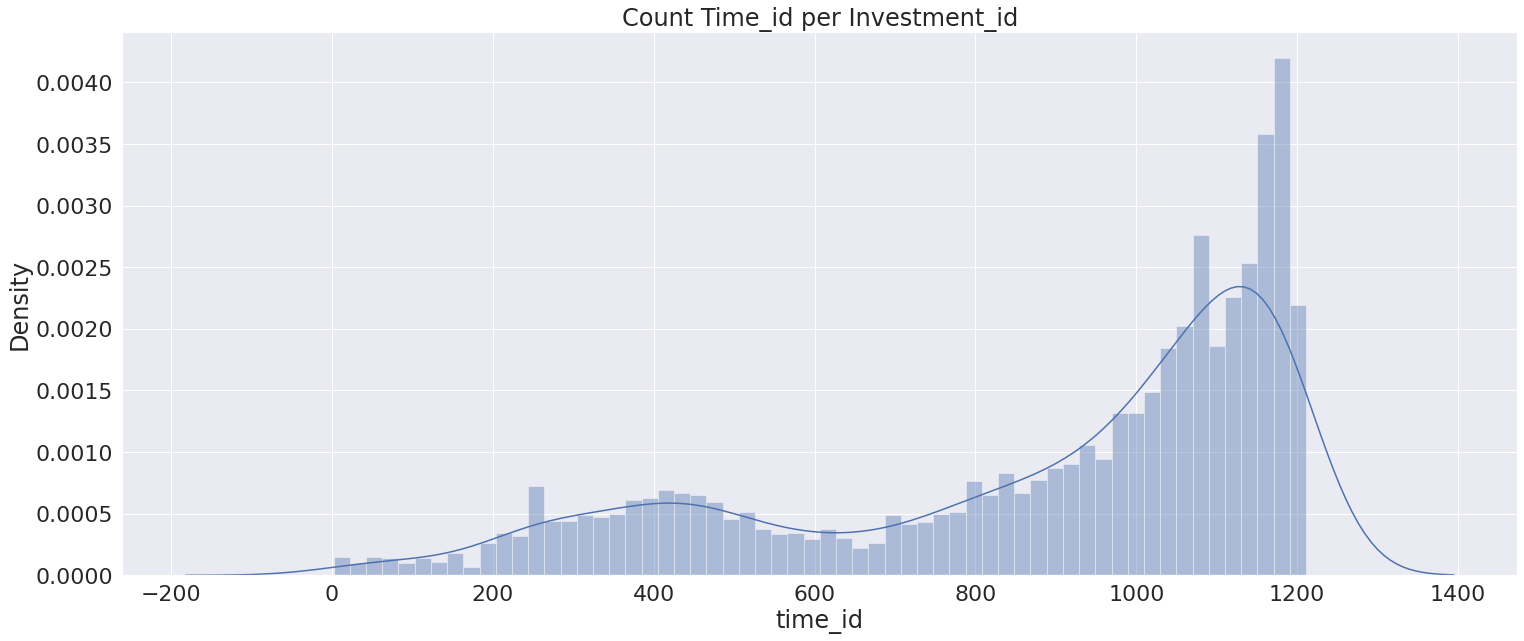

In [16]:
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.distplot(time_id_count, hist = True, bins=60)
plt.title('Count Time_id per Investment_id')
plt.show()

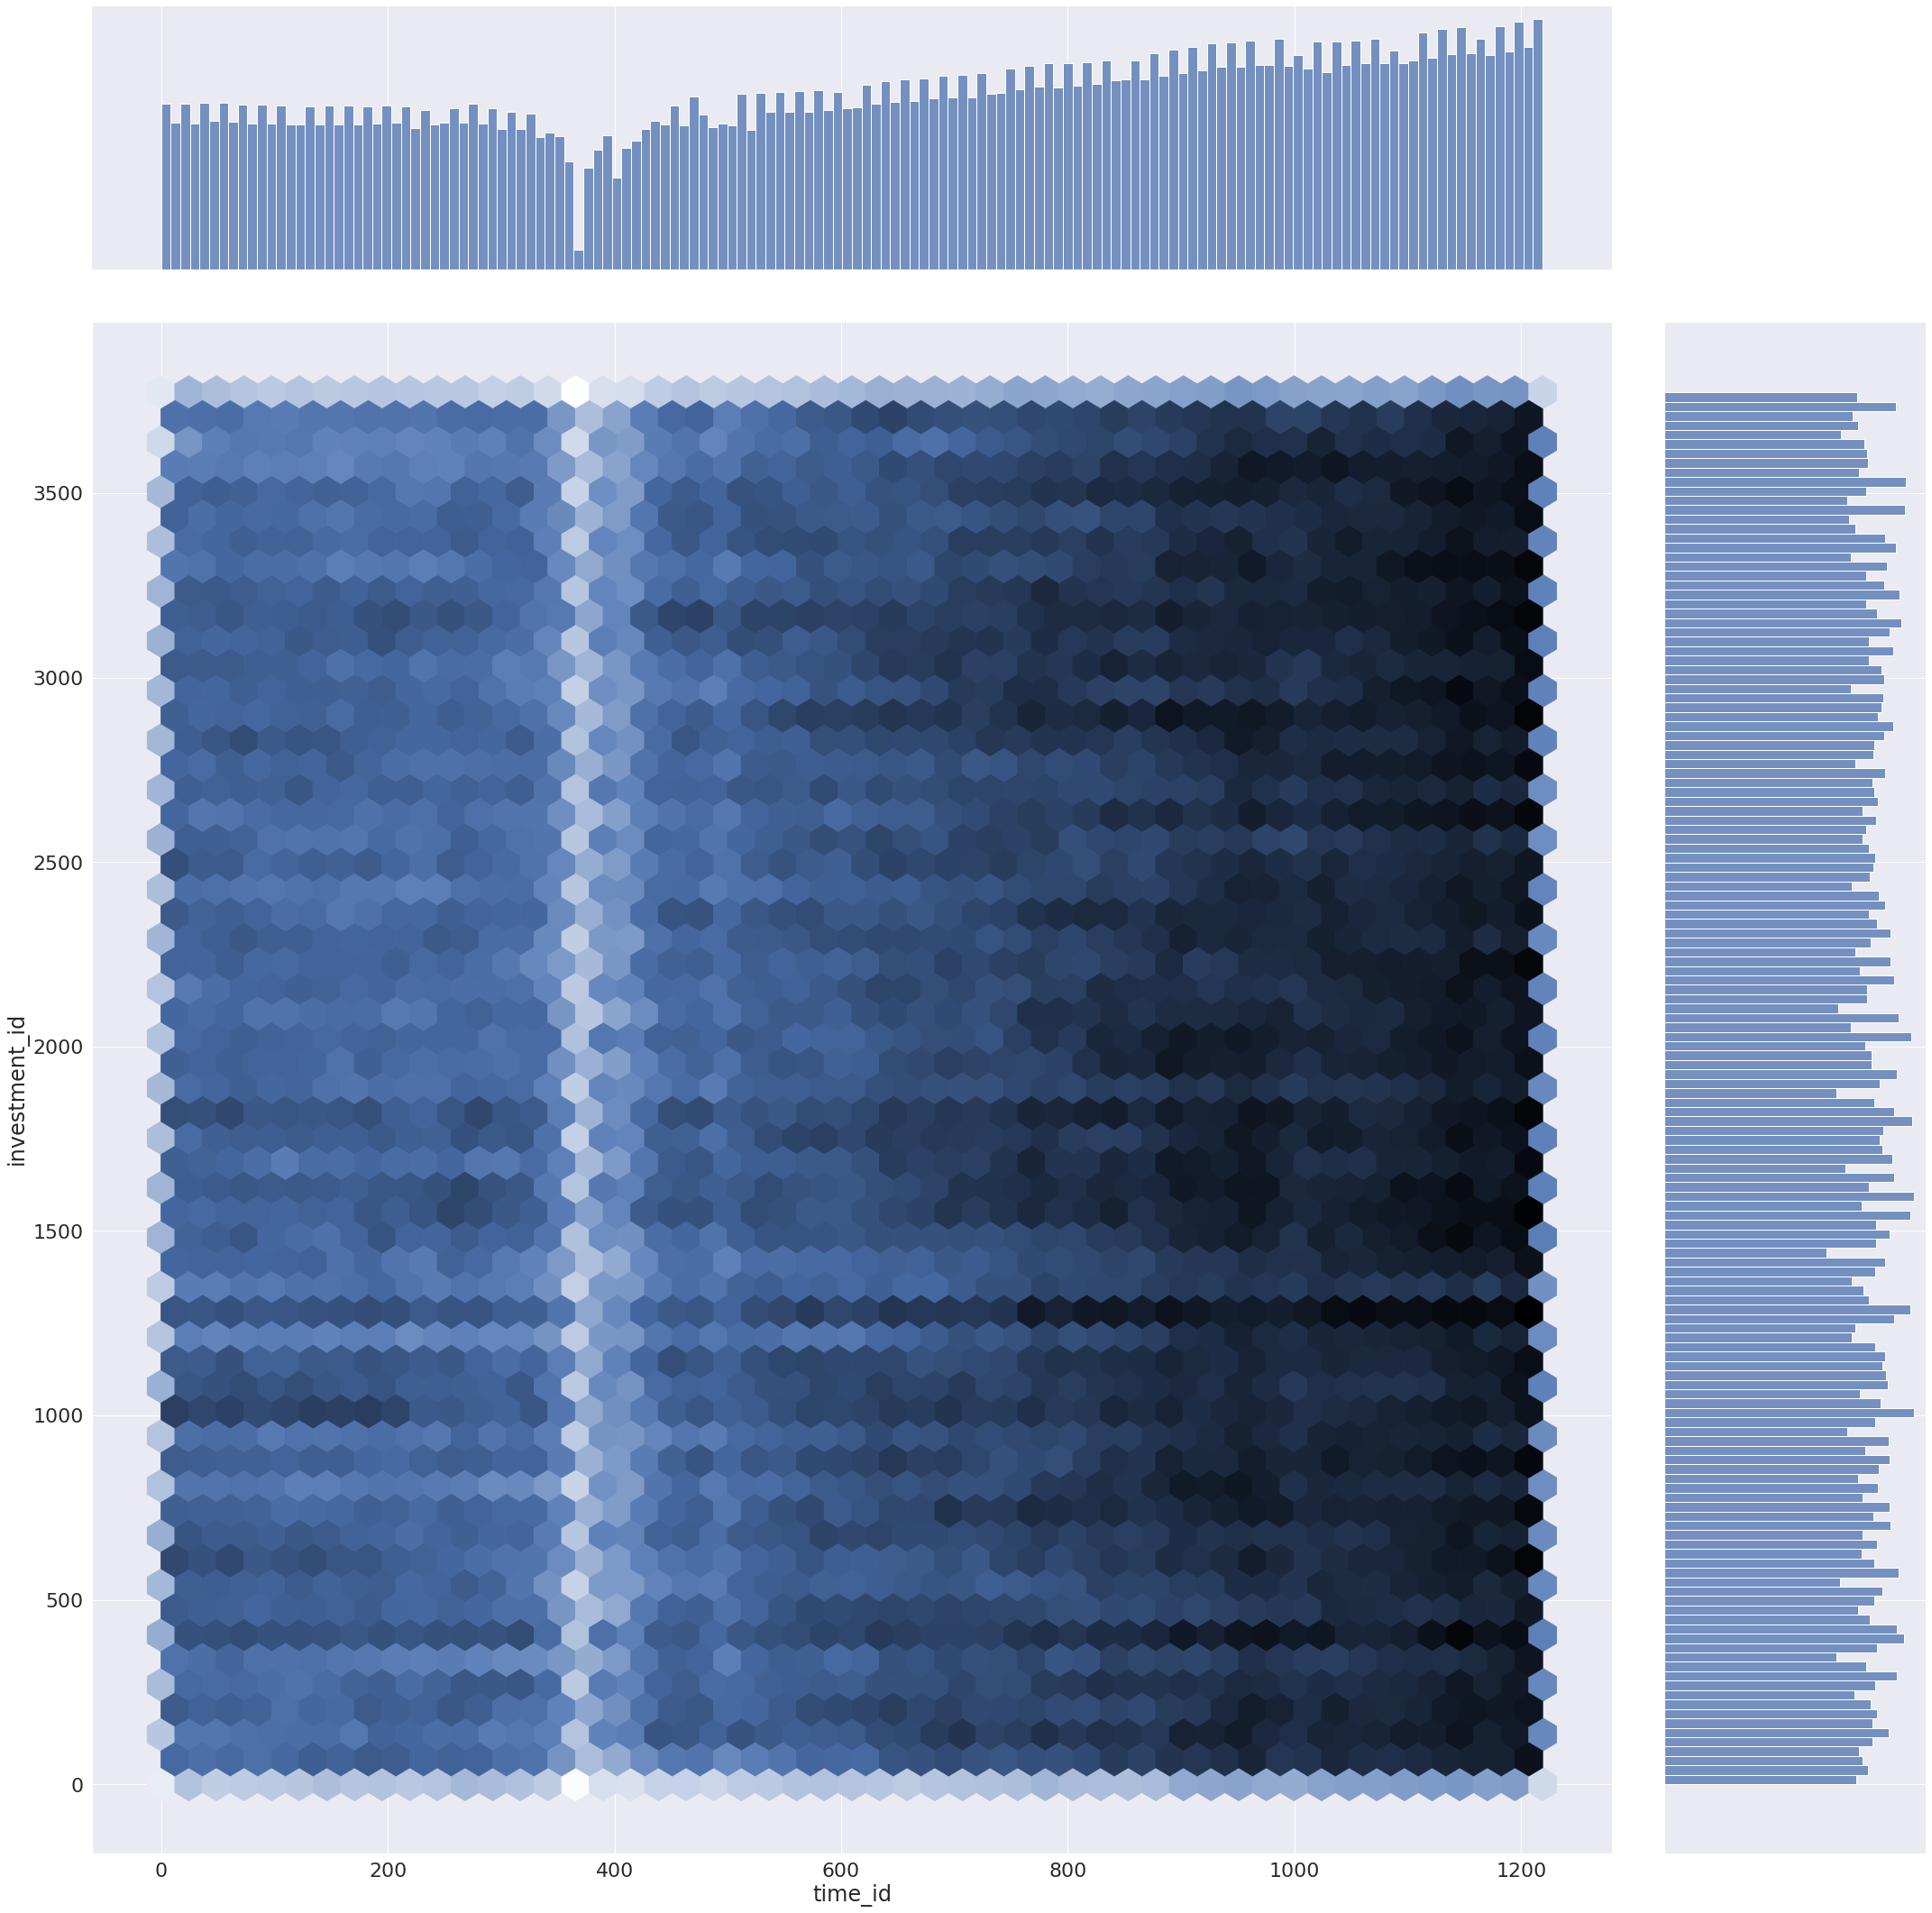

In [17]:
sns.jointplot(x = train_df['time_id'], y = train_df['investment_id'], kind='hex', height=30)

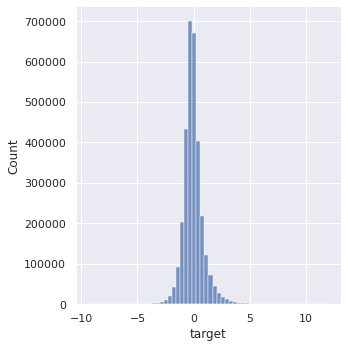

In [18]:
sns.set(font_scale=1)
ax = sns.displot(train_df['target'], bins=60)

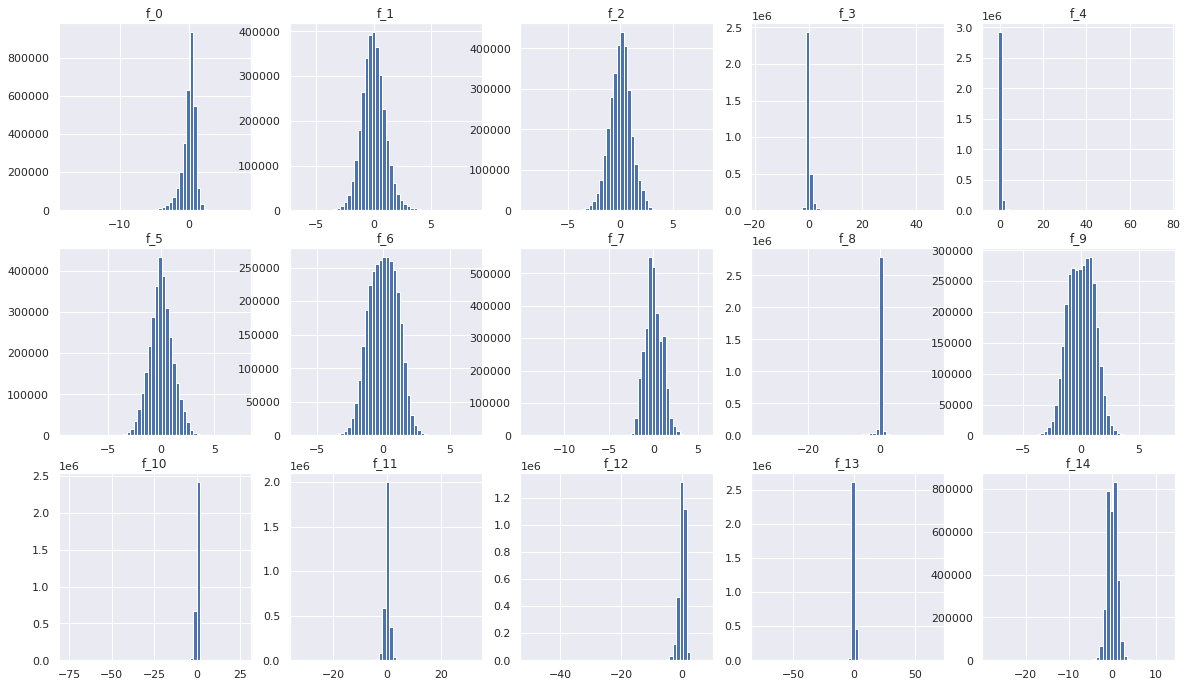

In [19]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
for i in range(0, 15):
    plt.subplot(5, 5, i+1)
    plt.hist(train_df[f"f_{i}"], bins=50)
    plt.title(f"f_{i}")
plt.show()

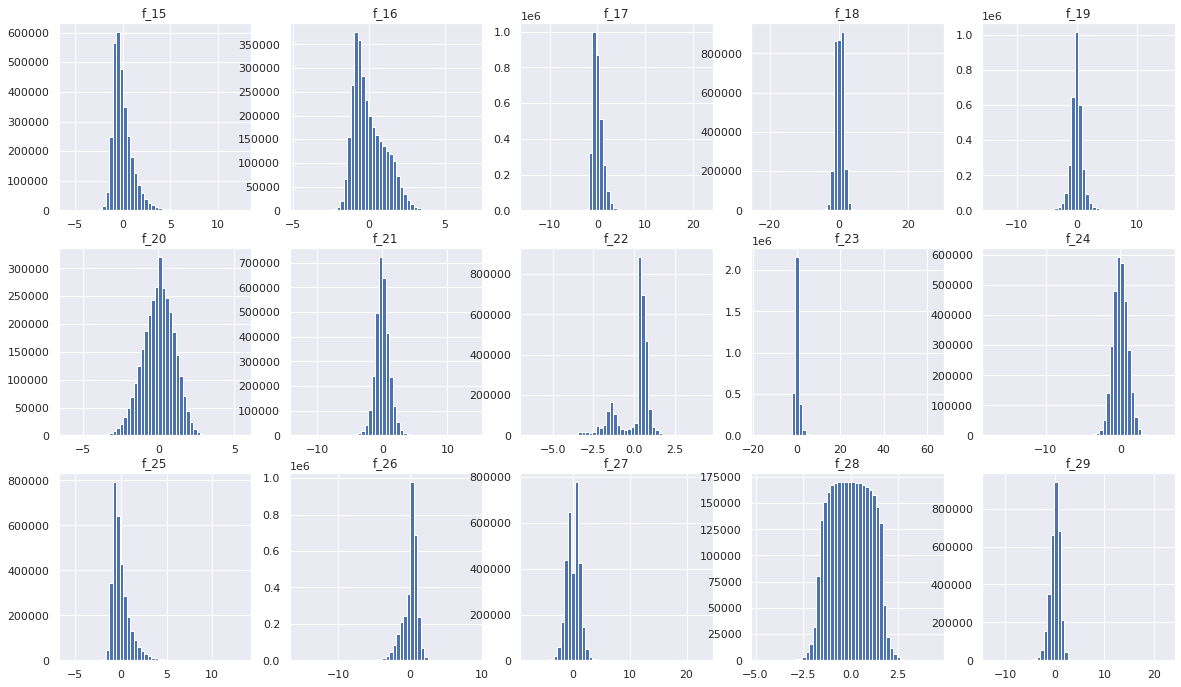

In [20]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
for i in range(15, 30):
    plt.subplot(5, 5, i-14)
    plt.hist(train_df[f"f_{i}"], bins=50)
    plt.title(f"f_{i}")
plt.show()

In [21]:
gc.collect()

80921

# Removing outliers

In [22]:
feature_cols = train_df.columns.unique()
print(feature_cols)

Index(['row_id', 'time_id', 'investment_id', 'target', 'f_0', 'f_1', 'f_2',
       'f_3', 'f_4', 'f_5',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=304)


In [23]:
feature_cols = feature_cols.drop(['row_id', 'target'])
print(feature_cols)

Index(['time_id', 'investment_id', 'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5',
       'f_6', 'f_7',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=302)


## (std * extreme_num, std * less_num, length) combinations and counts of outliers

|extreme_num|less_num|length|outliers|
|:------:|:------:|:------:|:------:|
|70|35|6|**174**|
|70|35|5|**158**|
|70|35|4|**151**|

In [24]:
outlier_list = []
outlier_col = []
extreme_num = 70
less_num = 35
length = 6

for col in feature_cols:
    tmp_df_1 = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * extreme_num) |
                     (train_df[col] < train_df[col].mean() - train_df[col].std() * extreme_num)]
    tmp_df_2 = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * less_num) |
                     (train_df[col] < train_df[col].mean() - train_df[col].std() * less_num)]
    
    if len(tmp_df_1) > 0:
        outliers = tmp_df_1.index.to_list()
        outlier_list.extend(outliers)
        print(col, len(tmp_df_1))
    elif len(tmp_df_2) > 0 and len(tmp_df_2) < length :
        outliers = tmp_df_2.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(tmp_df_2))

outlier_list = list(set(outlier_list))
print(len(outlier_list))

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 4
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 4
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
174


In [25]:
outlier_list = []
outlier_col = []
extreme_num = [60, 65, 70, 75, 80]
less_num = [30, 35, 40, 45, 50]
length = [3, 4, 5, 6, 7, 8]
cnt = 0
final_list = []
            
for i in tqdm(range(len(extreme_num))):
    for j in range(len(less_num)):
        for k in range(len(length)):
            for col in feature_cols:
                tmp_df_1 = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * extreme_num[i]) |
                                 (train_df[col] < train_df[col].mean() - train_df[col].std() * extreme_num[i])]
                tmp_df_2 = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * less_num[j]) |
                                 (train_df[col] < train_df[col].mean() - train_df[col].std() * less_num[j])]
    
                if len(tmp_df_1) > 0:
                    outliers = tmp_df_1.index.to_list()
                    outlier_list.extend(outliers)
                elif len(tmp_df_2) > 0 and len(tmp_df_2) < length[k] :
                    outliers = tmp_df_2.index.to_list()
                    outlier_list.extend(outliers)
                    outlier_col.append(col)

            outlier_list = list(set(outlier_list))
            final_list.append(outlier_list)
            print(f'{cnt} - extreme_num : {extreme_num[i]}, less_num : {less_num[j]}, length : {length[k]}, count : {len(outlier_list)}')
            cnt += 1

  0%|          | 0/5 [00:00<?, ?it/s]

0 - extreme_num : 60, less_num : 30, length : 3, count : 339
1 - extreme_num : 60, less_num : 30, length : 4, count : 345
2 - extreme_num : 60, less_num : 30, length : 5, count : 347
3 - extreme_num : 60, less_num : 30, length : 6, count : 353
4 - extreme_num : 60, less_num : 30, length : 7, count : 367
5 - extreme_num : 60, less_num : 30, length : 8, count : 367
6 - extreme_num : 60, less_num : 35, length : 3, count : 370
7 - extreme_num : 60, less_num : 35, length : 4, count : 373
8 - extreme_num : 60, less_num : 35, length : 5, count : 377
9 - extreme_num : 60, less_num : 35, length : 6, count : 392
10 - extreme_num : 60, less_num : 35, length : 7, count : 397
11 - extreme_num : 60, less_num : 35, length : 8, count : 399
12 - extreme_num : 60, less_num : 40, length : 3, count : 399
13 - extreme_num : 60, less_num : 40, length : 4, count : 399
14 - extreme_num : 60, less_num : 40, length : 5, count : 403
15 - extreme_num : 60, less_num : 40, length : 6, count : 403
16 - extreme_num :

 20%|██        | 1/5 [09:11<36:47, 551.76s/it]

29 - extreme_num : 60, less_num : 50, length : 8, count : 436
30 - extreme_num : 65, less_num : 30, length : 3, count : 436
31 - extreme_num : 65, less_num : 30, length : 4, count : 436
32 - extreme_num : 65, less_num : 30, length : 5, count : 436
33 - extreme_num : 65, less_num : 30, length : 6, count : 436
34 - extreme_num : 65, less_num : 30, length : 7, count : 436
35 - extreme_num : 65, less_num : 30, length : 8, count : 436
36 - extreme_num : 65, less_num : 35, length : 3, count : 436
37 - extreme_num : 65, less_num : 35, length : 4, count : 436
38 - extreme_num : 65, less_num : 35, length : 5, count : 436
39 - extreme_num : 65, less_num : 35, length : 6, count : 436
40 - extreme_num : 65, less_num : 35, length : 7, count : 436
41 - extreme_num : 65, less_num : 35, length : 8, count : 436
42 - extreme_num : 65, less_num : 40, length : 3, count : 436
43 - extreme_num : 65, less_num : 40, length : 4, count : 436
44 - extreme_num : 65, less_num : 40, length : 5, count : 436
45 - ext

 40%|████      | 2/5 [18:12<27:16, 545.50s/it]

59 - extreme_num : 65, less_num : 50, length : 8, count : 447
60 - extreme_num : 70, less_num : 30, length : 3, count : 447
61 - extreme_num : 70, less_num : 30, length : 4, count : 447
62 - extreme_num : 70, less_num : 30, length : 5, count : 447
63 - extreme_num : 70, less_num : 30, length : 6, count : 447
64 - extreme_num : 70, less_num : 30, length : 7, count : 447
65 - extreme_num : 70, less_num : 30, length : 8, count : 447
66 - extreme_num : 70, less_num : 35, length : 3, count : 447
67 - extreme_num : 70, less_num : 35, length : 4, count : 447
68 - extreme_num : 70, less_num : 35, length : 5, count : 447
69 - extreme_num : 70, less_num : 35, length : 6, count : 447
70 - extreme_num : 70, less_num : 35, length : 7, count : 447
71 - extreme_num : 70, less_num : 35, length : 8, count : 447
72 - extreme_num : 70, less_num : 40, length : 3, count : 447
73 - extreme_num : 70, less_num : 40, length : 4, count : 447
74 - extreme_num : 70, less_num : 40, length : 5, count : 447
75 - ext

 60%|██████    | 3/5 [27:16<18:09, 544.61s/it]

89 - extreme_num : 70, less_num : 50, length : 8, count : 447
90 - extreme_num : 75, less_num : 30, length : 3, count : 447
91 - extreme_num : 75, less_num : 30, length : 4, count : 447
92 - extreme_num : 75, less_num : 30, length : 5, count : 447
93 - extreme_num : 75, less_num : 30, length : 6, count : 447
94 - extreme_num : 75, less_num : 30, length : 7, count : 447
95 - extreme_num : 75, less_num : 30, length : 8, count : 447
96 - extreme_num : 75, less_num : 35, length : 3, count : 447
97 - extreme_num : 75, less_num : 35, length : 4, count : 447
98 - extreme_num : 75, less_num : 35, length : 5, count : 447
99 - extreme_num : 75, less_num : 35, length : 6, count : 447
100 - extreme_num : 75, less_num : 35, length : 7, count : 447
101 - extreme_num : 75, less_num : 35, length : 8, count : 447
102 - extreme_num : 75, less_num : 40, length : 3, count : 447
103 - extreme_num : 75, less_num : 40, length : 4, count : 447
104 - extreme_num : 75, less_num : 40, length : 5, count : 447
105

 80%|████████  | 4/5 [36:14<09:01, 541.92s/it]

119 - extreme_num : 75, less_num : 50, length : 8, count : 456
120 - extreme_num : 80, less_num : 30, length : 3, count : 456
121 - extreme_num : 80, less_num : 30, length : 4, count : 456
122 - extreme_num : 80, less_num : 30, length : 5, count : 456
123 - extreme_num : 80, less_num : 30, length : 6, count : 456
124 - extreme_num : 80, less_num : 30, length : 7, count : 456
125 - extreme_num : 80, less_num : 30, length : 8, count : 456
126 - extreme_num : 80, less_num : 35, length : 3, count : 456
127 - extreme_num : 80, less_num : 35, length : 4, count : 456
128 - extreme_num : 80, less_num : 35, length : 5, count : 456
129 - extreme_num : 80, less_num : 35, length : 6, count : 456
130 - extreme_num : 80, less_num : 35, length : 7, count : 456
131 - extreme_num : 80, less_num : 35, length : 8, count : 456
132 - extreme_num : 80, less_num : 40, length : 3, count : 456
133 - extreme_num : 80, less_num : 40, length : 4, count : 456
134 - extreme_num : 80, less_num : 40, length : 5, coun

100%|██████████| 5/5 [45:20<00:00, 544.04s/it]

149 - extreme_num : 80, less_num : 50, length : 8, count : 456


In [26]:
print(np.shape(final_list))

(150,)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
